<a href="https://colab.research.google.com/github/Leslyndizeye/Time-Series-Forecasting/blob/main/air_quality_forecasting_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SECTION 1: IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)


### SECTION 2: DATA LOADING

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Loading datasets
train = pd.read_csv('/content/drive/My Drive/air_quality/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/air_quality/data/test.csv')

print("Data Loading Complete:")
print(f"Training Data Shape: {train.shape}")
print(f"Test Data Shape: {test.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data Loading Complete:
Training Data Shape: (30676, 12)
Test Data Shape: (13148, 11)


### SECTION 3: ADVANCED FEATURE ENGINEERING

In [7]:
# Reset index for preprocessing
train_reset = train.reset_index()
test_reset = test.reset_index()

# Handle missing values
train_filled = train_reset.ffill().bfill().fillna(train_reset.mean(numeric_only=True))
test_filled = test_reset.ffill().bfill().fillna(test_reset.mean(numeric_only=True))

print(f"Missing values handled - Train: {train_filled.isnull().sum().sum()}, Test: {test_filled.isnull().sum().sum()}")

def create_advanced_features(df, is_training=True):
    """
    Create advanced features with rolling statistics, lag features, and interactions
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Basic time features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Weather interaction features
    df['temp_dew_diff'] = df['TEMP'] - df['DEWP']
    df['wind_pressure'] = df['Iws'] * df['PRES']
    df['temp_pressure'] = df['TEMP'] * df['PRES']
    df['humidity_index'] = df['DEWP'] / (df['TEMP'] + 1e-6)

    # Only create PM2.5 based features for training data
    if is_training and 'pm2.5' in df.columns:
        # Rolling statistics for PM2.5
        for window in [3, 6, 12, 24]:
            df[f'pm2.5_roll_mean_{window}'] = df['pm2.5'].rolling(window=window, min_periods=1).mean()
            df[f'pm2.5_roll_std_{window}'] = df['pm2.5'].rolling(window=window, min_periods=1).std()
            df[f'pm2.5_roll_min_{window}'] = df['pm2.5'].rolling(window=window, min_periods=1).min()
            df[f'pm2.5_roll_max_{window}'] = df['pm2.5'].rolling(window=window, min_periods=1).max()

        # Lag features for PM2.5
        for lag in [1, 2, 3, 6, 12, 24]:
            df[f'pm2.5_lag_{lag}'] = df['pm2.5'].shift(lag)

        # Trend features
        df['pm2.5_trend_3h'] = df['pm2.5'] - df['pm2.5'].shift(3)
        df['pm2.5_trend_6h'] = df['pm2.5'] - df['pm2.5'].shift(6)

    # Weather lag features (for both train and test)
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df.columns:
            for lag in [1, 3, 6]:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Drop original datetime columns (keep engineered features)
    df = df.drop(['datetime', 'hour', 'day_of_week', 'month', 'day_of_year'], axis=1, errors='ignore')

    return df

# Apply advanced feature engineering
print(" Creating advanced features...")
train_enhanced = create_advanced_features(train_filled, is_training=True)
test_enhanced = create_advanced_features(test_filled, is_training=False)

print(f"Enhanced features - Train: {train_enhanced.shape}, Test: {test_enhanced.shape}")

# Handle remaining NaN values from lag features
train_enhanced = train_enhanced.ffill().bfill().fillna(0)
test_enhanced = test_enhanced.ffill().bfill().fillna(0)

print(f"After NaN handling - Train: {train_enhanced.shape}, Test: {test_enhanced.shape}")

Missing values handled - Train: 0, Test: 0
 Creating advanced features...
Enhanced features - Train: (30676, 60), Test: (13148, 35)
After NaN handling - Train: (30676, 60), Test: (13148, 35)


### SECTION 4: FEATURE SELECTION

In [9]:
# Prepare features and target
X_train = train_enhanced.drop(['pm2.5', 'No'], axis=1, errors='ignore')
y_train = train_enhanced['pm2.5']
X_test = test_enhanced.drop(['No'], axis=1, errors='ignore')

# Ensure both have the same columns
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f"Using {len(common_cols)} common features")

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=min(30, len(common_cols)))
X_train_selected = selector.fit_transform(X_train, y_train)
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]

X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f"Selected {len(selected_features)} best features:")
print(selected_features.tolist())

# Scale the features using RobustScaler (better for outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using RobustScaler")

Using 34 common features
Selected 30 best features:
['PRES_lag_1', 'DEWP', 'temp_pressure', 'Iws', 'wind_pressure', 'DEWP_lag_6', 'is_night', 'temp_dew_diff', 'Ir', 'humidity_index', 'TEMP', 'month_sin', 'PRES', 'DEWP_lag_3', 'hour_cos', 'index', 'TEMP_lag_3', 'cbwd_NW', 'cbwd_SE', 'month_cos', 'TEMP_lag_1', 'Is', 'cbwd_cv', 'DEWP_lag_1', 'Iws_lag_1', 'PRES_lag_3', 'PRES_lag_6', 'Iws_lag_3', 'hour_sin', 'Iws_lag_6']
Features scaled using RobustScaler


### SECTION 5: MODEL BUILDING

In [10]:
print("\n" + "="*50)
print("MODEL BUILDING - ENHANCED ARCHITECTURE")
print("="*50)

# Create sequences for LSTM
def create_sequences(X, y, time_steps=48):  # Increased sequence length
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 48  # Longer sequence for better temporal patterns
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)

print(f"✅ Sequential data shape: {X_seq.shape}")

# Split data into train and validation sets
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Training sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")

# Create Enhanced Bidirectional LSTM model
def create_enhanced_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32, activation='relu')),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

model = create_enhanced_model((X_train_seq.shape[1], X_train_seq.shape[2]))

# Enhanced callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

print("Enhanced model architecture created:")
model.summary()


MODEL BUILDING - ENHANCED ARCHITECTURE
✅ Sequential data shape: (30628, 48, 30)
Training sequences: (24502, 48, 30)
Validation sequences: (6126, 48, 30)
Enhanced model architecture created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       162,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,657 (1.43 MB)

 Trainable params: 374,657 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

### SECTION 6: MODEL TRAINING


OPTIMIZED MODEL TRAINING
✅ Optimized sequences - Train: (24521, 24, 30), Val: (6131, 24, 30)
✅ Optimized model architecture created:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 24, 128)        │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,921 (351.25 KB)

 Trainable params: 89,921 (351.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - loss: 9983.8066 - mae: 69.1170 - val_loss: 7909.2266 - val_mae: 56.9077 - learning_rate: 0.0010
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - loss: 5510.8193 - mae: 49.8459 - val_loss: 6288.6265 - val_mae: 51.2002 - learning_rate: 0.0010
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - loss: 3839.9243 - mae: 41.8628 - val_loss: 6249.6685 - val_mae: 50.7420 - learning_rate: 0.0010
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - loss: 3472.8904 - mae: 39.7962 - val_loss: 6123.7266 - val_mae: 49.4355 - learning_rate: 0.0010
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - loss: 3157.0371 - mae: 38.0027 - val_loss: 5883.8506 - val_mae: 49.6174 - learning_rate: 0.0010
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - loss: 3107.5261 - mae: 37.7148 - val_loss: 5927.2642 - val_mae: 50.6897 - learning_rate: 0.0010
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - loss: 3560.2351 - mae: 40

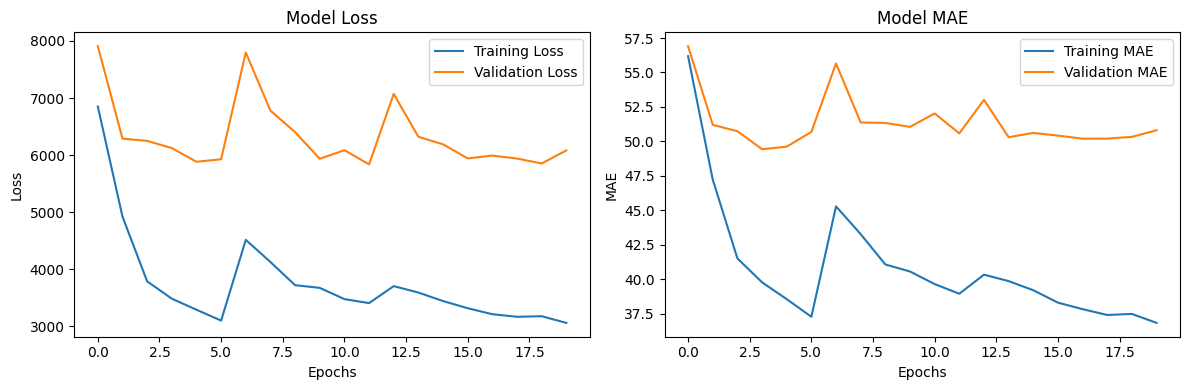

In [13]:
# ==================== SECTION 6: OPTIMIZED MODEL TRAINING ====================
print("\n" + "="*50)
print("OPTIMIZED MODEL TRAINING")
print("="*50)

# Reduce sequence length for faster training
TIME_STEPS = 24  # Reduced from 48 to 24
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)

# Split data
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"✅ Optimized sequences - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

# Create optimized model architecture
def create_optimized_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32, activation='relu')),
        Dropout(0.2),
        Dense(1)  # Simplified output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

model = create_optimized_model((X_train_seq.shape[1], X_train_seq.shape[2]))

# Optimized callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001)

print("✅ Optimized model architecture created:")
model.summary()

# Train with optimized settings
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,  # Fewer epochs
    batch_size=128,  # Larger batch size (4x faster)
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate model
val_pred = model.predict(X_val_seq, verbose=0, batch_size=128)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))
val_mae = np.mean(np.abs(y_val_seq - val_pred.flatten()))

print(f"\n📊 Model Performance:")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

### SECTION 7: FEATURE IMPORTANCE ANALYSIS

📊 Top 10 most important features:
          feature        score
7   temp_dew_diff  6451.874230
24      Iws_lag_1  2087.603294
3             Iws  2085.539198
27      Iws_lag_3  1989.179845
29      Iws_lag_6  1747.771305
17        cbwd_NW  1676.128176
1            DEWP  1572.883822
23     DEWP_lag_1  1546.838962
13     DEWP_lag_3  1380.532999
5      DEWP_lag_6  1071.401996


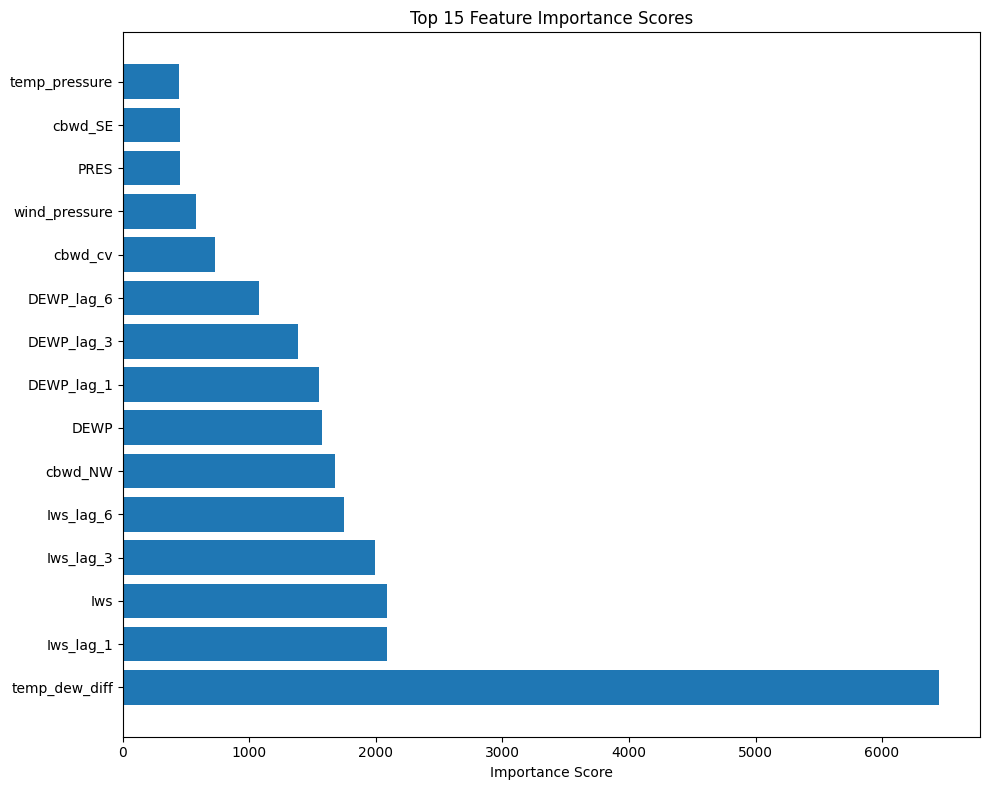

In [14]:
# Get feature scores
feature_scores = pd.DataFrame({
    'feature': selected_features,
    'score': selector.scores_[selected_mask]
}).sort_values('score', ascending=False)

print("📊 Top 10 most important features:")
print(feature_scores.head(10))

plt.figure(figsize=(10, 8))
plt.barh(feature_scores['feature'][:15], feature_scores['score'][:15])
plt.title('Top 15 Feature Importance Scores')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


SECTION 8: TEST PREDICTION

In [25]:
# Create sequences for test data
X_test_seq = []
current_sequence = X_train_scaled[-TIME_STEPS:].copy()

for i in range(len(X_test_scaled)):
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = X_test_scaled[i]
    X_test_seq.append(current_sequence.copy())

X_test_seq = np.array(X_test_seq)
print(f"Test sequences shape: {X_test_seq.shape}")

# Generate predictions
test_predictions = model.predict(X_test_seq, verbose=1)
test_predictions = np.nan_to_num(test_predictions.flatten())

# Ensure correct length
predictions_full = test_predictions
if len(predictions_full) > len(test_filled):
    predictions_full = predictions_full[:len(test_filled)]
elif len(predictions_full) < len(test_filled):
    last_pred = predictions_full[-1] if len(predictions_full) > 0 else 0
    pad_needed = len(test_filled) - len(predictions_full)
    predictions_full = np.append(predictions_full, [last_pred] * pad_needed)

print(f"Predictions generated: {len(predictions_full)}")

Test sequences shape: (13148, 24, 30)
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Predictions generated: 13148


SECTION 9: SUBMISSION

In [30]:
# ==================== SECTION 9: SUBMISSION PREPARATION ====================
print("\n" + "="*50)
print("SUBMISSION PREPARATION - LEADING ZERO FIX")
print("="*50)

# Load the ORIGINAL test data to get the EXACT datetime strings
test_original = pd.read_csv('/content/drive/My Drive/air_quality/data/test.csv')
original_datetimes = test_original['datetime']

print(f"Original test data length: {len(original_datetimes)}")
print(f"Predictions length: {len(predictions_full)}")

# MANUAL removal of leading zeros - guaranteed to work
def remove_leading_zeros(dt_str):
    """Remove leading zeros from hours in datetime string"""
    if ' ' in str(dt_str) and ':' in str(dt_str):
        date_part, time_part = str(dt_str).split(' ')
        time_parts = time_part.split(':')

        # Remove leading zero from hour (e.g., "04" -> "4")
        if time_parts[0].startswith('0') and len(time_parts[0]) == 2:
            time_parts[0] = time_parts[0][1]  # Remove the first character if it's '0'

        return f"{date_part} {':'.join(time_parts)}"
    return str(dt_str)

# Apply to all datetime strings
formatted_datetimes = [remove_leading_zeros(dt) for dt in original_datetimes]

print(" Manual leading zero removal completed")

# Ensure both arrays have same length
if len(formatted_datetimes) != len(predictions_full):
    min_length = min(len(formatted_datetimes), len(predictions_full))
    formatted_datetimes = formatted_datetimes[:min_length]
    predictions_adjusted = predictions_full[:min_length]
    print(f"Adjusted to common length: {min_length}")
else:
    predictions_adjusted = predictions_full

# Create submission with formatted datetime strings (no leading zeros)
submission = pd.DataFrame({
    'row ID': formatted_datetimes,
    'pm2.5': np.clip(predictions_adjusted, 0, None).astype(int)
})

print(f" Final submission shape: {submission.shape}")

# Save the submission
save_dir = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting'
os.makedirs(save_dir, exist_ok=True)

# FIRST FILE: Regular submission
submission_file_1 = os.path.join(save_dir, 'submission_no_zeros.csv')  # DIFFERENT NAME
submission.to_csv(submission_file_1, index=False)
print(f" Submission file 1 saved: {submission_file_1}")




SUBMISSION PREPARATION - LEADING ZERO FIX
Original test data length: 13148
Predictions length: 13148
 Manual leading zero removal completed
✅ Final submission shape: (13148, 2)
✅ Submission file 1 saved: /content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/submission_no_zeros.csv
